<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

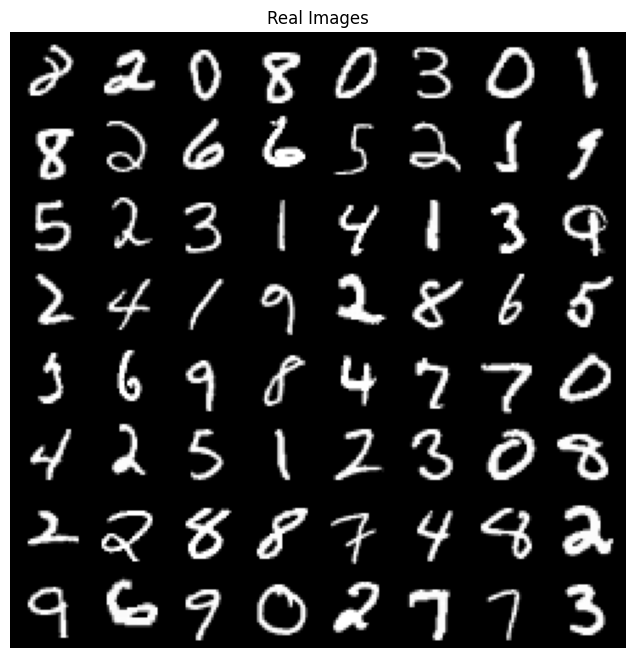

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

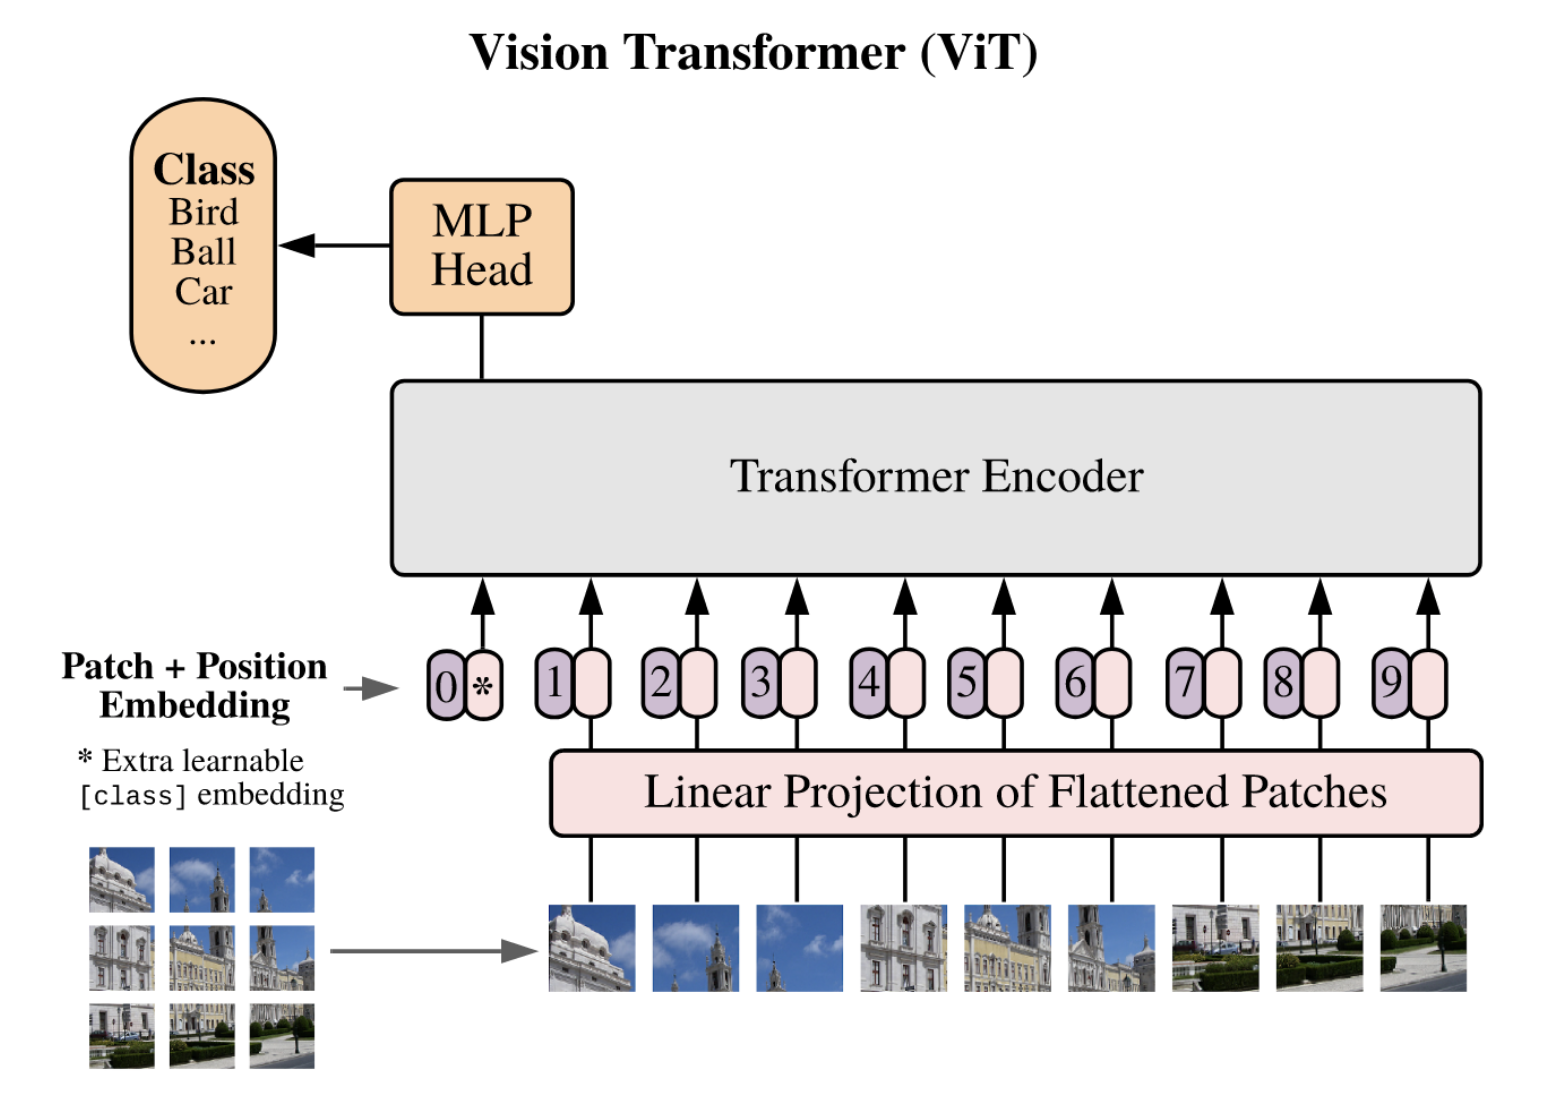

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128, padding = 0):
    super().__init__()
    ## TODO
    self.projection = torch.nn.Conv2d(in_chan,
                                      embed_dim,
                                      kernel_size=patch_size,
                                      stride=patch_size,
                                      padding=padding)

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape
    ## TODO
    x = torch.transpose(x.view(B, C, H*W), 1, 2)
    # x.shape() -> B, N, C
    return x

PatchEmbed(16, 7, 64)(torch.randn(1, 16, 32, 128)).shape

torch.Size([1, 72, 64])

# Transformer encoder

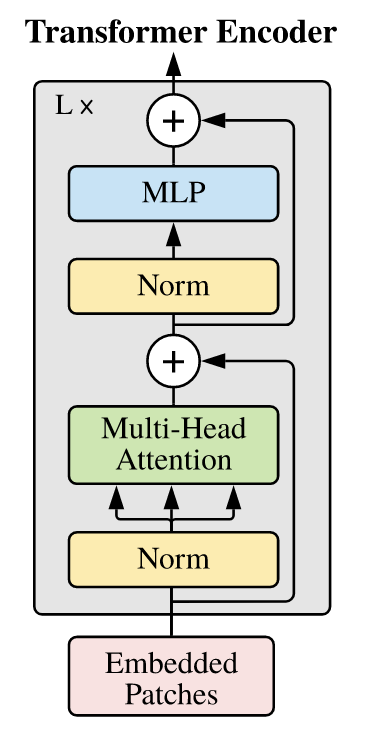

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    # TODO
    self.model = torch.nn.Sequential(
        torch.nn.Linear(in_features, hid_features),
        torch.nn.GELU(),
        torch.nn.Linear(hid_features, in_features),
        torch.nn.GELU()
    )

  def forward(self, x):
    # TODO
    x = self.model(x)
    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # TODO
    self.attention = torch.nn.Softmax()
    self.q = torch.nn.Linear(embed_dim, embed_dim, True)
    self.k = torch.nn.Linear(embed_dim, embed_dim, True)
    self.v = torch.nn.Linear(embed_dim, embed_dim, True)
    self.projection = torch.nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    # TODO: compute the attention matrix using Q and K
    attention = self.attention(q@torch.transpose(k, 1, 2)/np.sqrt(k.shape[0]))@v

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = self.projection(attention)

    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    self.head_dim = embed_dim//num_heads
    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads

    self.q = torch.nn.Linear(embed_dim, embed_dim, True)
    self.k = torch.nn.Linear(embed_dim, embed_dim, True)
    self.v = torch.nn.Linear(embed_dim, embed_dim, True)
    self.attention = torch.nn.Softmax()
    self.projection = torch.nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape
    q = self.q(x).view(B, N, self.num_heads, self.head_dim)
    k = self.k(x).view(B, N, self.num_heads, self.head_dim)
    v = self.v(x).view(B, N, self.num_heads, self.head_dim)

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO
    attention = (self.attention(q@torch.transpose(k, -1, -2)*self.scale)@v)
    attention = attention.view(B,N,C)

    x = self.projection(attention)

    return x


MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

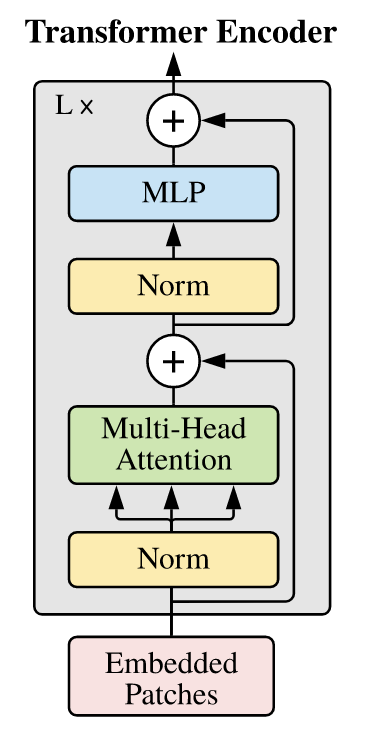

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    # TODO
    self.normalized_shape = (embed_dim,)
    self.in_features = embed_dim
    self.hid_features = embed_dim*mlp_ratio

    self.norm1 = torch.nn.LayerNorm(self.normalized_shape)
    self.multi_head_attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.norm2 = torch.nn.LayerNorm(self.normalized_shape)
    self.mlp = MLP(self.in_features, self.hid_features)

  def forward(self, x):
    y = self.multi_head_attention(self.norm1(x)) + x
    z = self.mlp(self.norm2(y))+y
    return z

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)

    self.nb_classes = nb_classes
    self.head = MLP(embed_dim, self.nb_classes)

  def forward(self, x):
    B, N, C, W = x.shape

    x = self.patch_embed(x) ## image to patches

    ## concatenating class token

    x = torch.cat((self.class_token.repeat(B, 1, 1), x), 1)
    ## adding positional embedding
    x = x + self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = self.norm(x)

    output = self.head(x[:, 0, :]) ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 128])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 1.6239958867462458
--- Epoch 1 ---
Train loss: 0.3945894793216099
--- Epoch 2 ---
Train loss: 0.24675681804225388
--- Epoch 3 ---
Train loss: 0.18997579917851795
--- Epoch 4 ---
Train loss: 0.1601106506198454
--- Epoch 5 ---
Train loss: 0.13936278904313598
--- Epoch 6 ---
Train loss: 0.12456407598944615
--- Epoch 7 ---
Train loss: 0.11150106314672971
--- Epoch 8 ---
Train loss: 0.1043413587327578
--- Epoch 9 ---
Train loss: 0.09570374628151658
Test accuracy: 96.55


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00


a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
model = timm.create_model('vit_base_patch16_224', img_size=28, num_classes=10)

In [ ]:
x = torch.randn(32, 1, 28, 28)
x = x.expand(-1, 3, -1, -1)

model(x).shape

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
model = timm.create_model('vit_base_patch16_224', img_size=28, num_classes=10)
x = torch.randn(32, 1, 28, 28)
x = x.expand(-1, 3, -1, -1)

model(x).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.expand(-1, 3, -1, -1)

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.expand(-1, 3, -1, -1)

    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 1.1514402445572525
--- Epoch 1 ---
Train loss: 0.6073188852272562
--- Epoch 2 ---
Train loss: 0.5205543890817842
--- Epoch 3 ---
Train loss: 0.47115566773709455
--- Epoch 4 ---
Train loss: 0.4467694540776169
--- Epoch 5 ---
Train loss: 0.4510755289846392
--- Epoch 6 ---
Train loss: 0.4222580088989567
--- Epoch 7 ---
Train loss: 0.40533606396682226
--- Epoch 8 ---
Train loss: 0.3924955674198899
--- Epoch 9 ---
Train loss: 0.38431268860536344
Test accuracy: 86.17


c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_base_patch16_224', img_size=28, num_classes=10, pretrained=True).cuda()

In [ ]:
import timm


epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.expand(-1, 3, -1, -1)

    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 0.8767229155945117
--- Epoch 1 ---
Train loss: 0.43856499453724573
--- Epoch 2 ---
Train loss: 0.3789828435571463
--- Epoch 3 ---
Train loss: 0.35370211169790866
--- Epoch 4 ---
Train loss: 0.33438390741216095
--- Epoch 5 ---
Train loss: 0.3183735007289122
--- Epoch 6 ---
Train loss: 0.30057241165561716
--- Epoch 7 ---
Train loss: 0.2942628828383712
--- Epoch 8 ---
Train loss: 0.2823508655878781
--- Epoch 9 ---
Train loss: 0.27185228851431215
Test accuracy: 90.52


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

# Results
We see that the pretrained model started with a lower loss and ended with a higher accuracy.  
We can therefore understand that the concept of sharing pretrained model helps a lot in having better results, even with a small dataset.  
A lot of methods can be used to make transformers work better on small dataset. For example, the bootstrap family of algorithm can be adapted in some ways to augment our data. Secondly, using a logic tagging on patches (by an expert, e.g. human) and then putting tagges patches together to form an image with acceptable tags (however, this method is more dangerous since this can lead to non-sensical images if not handled properly).  